In [1]:
import os, sys, time, resource, re, gc, shutil
from multiprocess import Pool
from functools import partial

from urllib.parse import urlparse, parse_qsl

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mongoengine.queryset.visitor import Q
import django
from django.db.models import Count
sys.path.append('/home/galm/software/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *


In [2]:
wos = Query.objects.get(pk=365)
scopus = Query.objects.get(pk=354)
both = Query.objects.get(pk=894)

In [3]:
#alldocs = Doc.objects.filter(query=wos) | Doc.objects.filter(query=scopus)
#alldocs = alldocs.distinct('UT')
alldocs = Doc.objects.filter(query=both)
print(alldocs.count())

444838


In [4]:
bypy = alldocs.values('PY').annotate(
    only_wos = models.Sum(
        models.Case(
            models.When(wos=True,scopus=False,then=1),default=0, output_field=models.IntegerField()
        )
    )
)
bypy2 = alldocs.values('PY').annotate(
    scopus = models.Sum(
        models.Case(
            models.When(scopus=True,wos=False,then=1),default=0, output_field=models.IntegerField()
        )
    )
)
bypy3 = alldocs.values('PY').annotate(
    both = models.Sum(
        models.Case(
            models.When(scopus=True,wos=True,then=1),default=0, output_field=models.IntegerField()
        )
    )
)



In [5]:
bypy = pd.DataFrame.from_dict(list(bypy))
bypy = bypy.merge(pd.DataFrame.from_dict(list(bypy2)))
bypy = bypy.merge(pd.DataFrame.from_dict(list(bypy3)))


bypy = bypy[bypy['PY']>1980]#.reset_index(drop=True)
bypy = bypy.sort_values(by='PY', ascending=1).reset_index(drop=True)

In [6]:


bypy['AP'] = pd.cut(bypy.PY,bins=[0,1985,1990.1,1995.1,2001.1,2007.1,2013.1,9999],labels=["NA","AR1","AR2","AR3","AR4","AR5","AR6"])
bypy['total'] = bypy.only_wos + bypy.scopus + bypy.both
bypy.head(25)

,PY,only_wos,scopus,both,AP,total
0,1981,58,431,69,NA,558
1,1982,70,419,58,NA,547
2,1983,97,462,82,NA,641
3,1984,89,575,83,NA,747
4,1985,62,473,89,NA,624
5,1986,78,423,117,AR1,618
6,1987,92,508,103,AR1,703
7,1988,94,615,134,AR1,843
8,1989,189,902,208,AR1,1299
9,1990,309,1270,373,AR1,1952


      total                   PY        
        sum          mean    sum    mean
AP                                      
NA     3117    623.400000   9915  1983.0
AR1    5415   1083.000000   9940  1988.0
AR2   15214   3042.800000   9965  1993.0
AR3   31954   5325.666667  11991  1998.5
AR4   72242  12040.333333  12027  2004.5
AR5  180238  30039.666667  12063  2010.5
AR6  133432  44477.333333   6045  2015.0


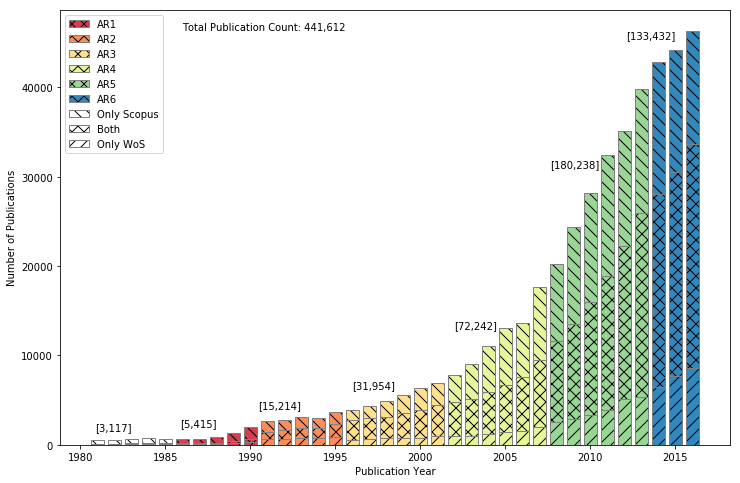

In [7]:
plt.rcParams["figure.figsize"] = [12,8]

bypy=bypy[bypy['PY']<2017]

edge="grey"
color = "white"

colors = {'NA':"white",'AR1':"#D53E4F", 'AR2':'#FC8D59', 'AR3':'#FEE08B', 'AR4':'#E6F598','AR5':'#99D594','AR6':'#3288BD'}

p1 = plt.bar(bypy.PY,bypy['only_wos'],color=bypy['AP'].apply(lambda x: colors[x]),edgecolor=edge, hatch=2*"/")
p2 = plt.bar(bypy.PY,bypy['both'],color=bypy['AP'].apply(lambda x: colors[x]),edgecolor=edge, hatch=2*"x",bottom=bypy['only_wos'])
p3 = plt.bar(bypy.PY,bypy['scopus'],color=bypy['AP'].apply(lambda x: colors[x]),edgecolor=edge, hatch=2*"\\",bottom=bypy['only_wos']+bypy['both'])

plt.legend(
    (p2[6],p2[10],p2[15],p2[22],p2[28],p2[35],p3[0],p2[0],p1[0]),
    ('AR1','AR2','AR3','AR4','AR5','AR6','Only Scopus','Both','Only WoS')
)

grouped = bypy[['AP','total','PY']].groupby('AP').agg([np.sum,np.mean])
print(grouped)
for index, row in grouped.iterrows():
    plt.text(
        row['PY']['mean'],
        row['total']['mean']+1000,
        "[{:,.0f}]".format(row['total']['sum']),
        ha='right'
    )

plt.text(1986,bypy.total.max(),"Total Publication Count: {:,}".format(bypy.total.sum()))
    #print(group.agg({}))
    
plt.xlabel('Publication Year')
plt.ylabel('Number of Publications')


plt.savefig('../plots/wos_scopus_docs_time.png',bbox_inches='tight')
plt.show()

In [8]:
bypy['total'] = bypy.only_wos + bypy.scopus + bypy.both
byap = bypy.groupby(['AP']).sum()
print(byap)

        PY  only_wos  scopus   both   total
AP                                         
NA    9915       376    2360    381    3117
AR1   9940       762    3718    935    5415
AR2   9965      3571    5938   5705   15214
AR3  11991      4492   11127  16335   31954
AR4  12027      8256   32665  31321   72242
AR5  12063     23132   71919  85187  180238
AR6   6045     22677   41108  69647  133432


In [9]:
bypy.total.sum()

441612